# https://www.depends-on-the-definition.com/named-entity-recognition-with-residual-lstm-and-elmo/
# http://hunterheidenreich.com/blog/elmo-word-vectors-in-keras/
* empt is performend on unballanced data set
* basic preprocessing
* one sent i/p @ a time with no seq length
* ["elmo_elmo"] embedding ==> [batch , maxLen, 1024]
* GRU 5 units

In [1]:
import string
import re

from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize

import tqdm

import pandas as pd
import numpy  as np

#import wordcloud
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import preprocessing

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Model
from keras.layers import Input, Lambda, CuDNNGRU,GRU
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers.recurrent import LSTM

import keras

import tensorflow as tf
import tensorflow_hub as hub

punct = set(string.punctuation)
stopWords = set(stopwords.words('english'))

tf.reset_default_graph()
sess = tf.InteractiveSession()

Using TensorFlow backend.


In [2]:
elmoEmbed = hub.Module("D:/dataset/Embedding/tf_module_ELMO2", trainable=False) 

In [3]:
%%time
df = pd.read_csv('spam.csv',encoding = "latin1" )

Wall time: 31.1 ms


In [4]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
df.describe()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""",GE,"GNT:-)"""
freq,4825,30,3,2,2


In [6]:
#delete those not unique
len(df[df["v2"] == "NaN"]) 

0

In [7]:
df['v1'].value_counts()

ham     4825
spam     747
Name: v1, dtype: int64

In [8]:
#perform textblob

def preProcess(review):
    token = word_tokenize(review) 
    tokens = [t.lower() for t in token]
    
    # rmv that are not alphabet
    tokens = [word for word in tokens if word.isalpha()]
    #rmv token that are of length 1
    tokens = [word for word in tokens if len(word) > 1]
    
    filterd_words = [word for word in tokens if word not in stopWords]
    return ' '.join(text for text in filterd_words if text not in punct)

In [9]:
preProcess(df['v2'].iloc[21])

'going try months ha ha joking'

In [10]:
df['v2'].iloc[21]

'I\x89Û÷m going to try for 2 months ha ha only joking'

In [11]:
def replace_contraction(text):
    contraction_patterns = [ (r'won\'t', 'will not'), (r'can\'t', 'can not'), (r'i\'m', 'i am'), (r'ain\'t', 'is not'),
                            (r'(\w+)\'ll', '\g<1> will'), (r'(\w+)n\'t', '\g<1> not'),(r'(\w+)\'ve', '\g<1> have'),
                            (r'(\w+)\'s', '\g<1> is'), (r'(\w+)\'re', '\g<1> are'), (r'(\w+)\'d', '\g<1> would'), 
                            (r'&', 'and'), (r'dammit', 'damn it'), (r'dont', 'do not'), (r'wont', 'will not') ]
    ''''''
    patterns = [(re.compile(regex), repl) for (regex, repl) in contraction_patterns]
    for (pattern, repl) in patterns:
        (text, count) = re.subn(pattern, repl, text)
    return text

#can run spell checker

#find max_length to detect freq distribution

def remove_numbers(text):
    tokens = word_tokenize(text) 
    # rmv that are not alphabet
    tokens = [word for word in tokens if word.isalpha()]
    #rmv token that are of length 1
    tokens = [word for word in tokens if len(word) > 1]
    # text = ''.join([i for i in tokens if not i.isdigit()])
    return ' '.join(text for text in tokens if text not in punct)

In [12]:
x = "hey there's but i'm , not can't so  http 5877456 @miki wont come dammit  won't haven't musn't be there mightn't happened"
print(replace_contraction(x))

hey there is but i am , not can not so  http 5877456 @miki will not come damn it  will not have not mus not be there might not happened


In [13]:
remove_numbers("hey there is but. i am , not % $can not $  so / : @ * () http 5877456 @miki will not come damn it  will not")

'hey there is but am not can not so http miki will not come damn it will not'

In [14]:
df['v2'].iloc[21]

'I\x89Û÷m going to try for 2 months ha ha only joking'

In [15]:
df["v2"] = df["v2"].apply(lambda x : remove_numbers(replace_contraction(x)))

In [16]:
#  overall avg length of text review , before / after  any pre processing
def word_count_in_review(review):
    tokens = word_tokenize(review)
    return len(tokens)  

#freq distribution lenght of data
def stats_of_freq_distribution(freq_column):
    print("MEAN length of data set :",np.mean(freq_column))
    print("MEDIAN length of data set :",np.median(freq_column))
    print("STD DEV length of data set :",np.std(freq_column))
    print("MAX token of data set :",np.max(freq_column))
    print("MIN token of data set :",np.min(freq_column))
    
def plot_length_distribution(freq_column):
    plt.hist(freq_column, bins=50)
    plt.xlabel('Length of a sample')
    plt.ylabel('Number of samples')
    plt.title('Sample length distribution')
    plt.show()


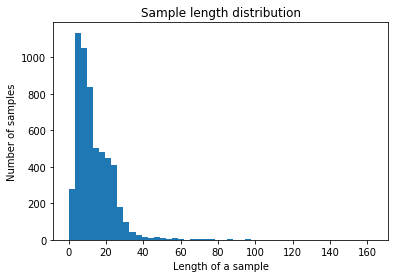

In [17]:
df["word_count"] = df["v2"].apply(lambda x : word_count_in_review(x))
plot_length_distribution(df['word_count'])

In [18]:
stats_of_freq_distribution(df['word_count'])

MEAN length of data set : 13.486898779612348
MEDIAN length of data set : 11.0
STD DEV length of data set : 9.908555727210217
MAX token of data set : 163
MIN token of data set : 0


In [19]:
MAX_LEN= 38
np.sum(df['word_count'] < MAX_LEN) / len(df['word_count'])


0.9820531227566404

In [20]:
from keras.preprocessing import sequence
data = sequence.pad_sequences(df['v2'] , maxlen=38,padding='pre', truncating='pre')

ValueError: invalid literal for int() with base 10: 'rld la buffet Cine there got amore wat'

In [ ]:
y = list(df['v1'])  #label
x = list(df['v2']) #data

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(y)

In [ ]:
def encode(le, labels):
    enc = le.transform(labels)
    return keras.utils.to_categorical(enc)

In [ ]:
def decode(le, one_hot):
    dec = np.argmax(one_hot, axis=1)
    return le.inverse_transform(dec)

In [ ]:
encode(le, ['ham', 'spam', 'ham', 'ham'])

In [ ]:
x_enc = x
y_enc = encode(le, y)

x_train = np.asarray(x_enc[:5000])
y_train = np.asarray(y_enc[:5000])

x_test = np.asarray(x_enc[5000:])
y_test = np.asarray(y_enc[5000:])

In [ ]:
def ELMoEmbedding(x):
    return elmoEmbed(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["elmo"]

In [ ]:
'''
input_text = Input(shape=(120,1), dtype=tf.string)
embedding = Lambda(ELMoEmbedding, output_shape=(1024, ))(input_text)
hidden1 = LSTM(40)(embedding)
output = Dense(1, activation='sigmoid')(hidden1)
model = Model(inputs=[input_text], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
'''


In [ ]:
input_text = Input(shape=(1,), dtype=tf.string)
embedding = Lambda(ELMoEmbedding, output_shape=(None,1024 ))(input_text)
'''
may be batches are uneven
may be text seq lenth for GRU to process is uneve
may be that specific error in console
'''
dense =  CuDNNGRU(units=5)(embedding)
#dense =  LSTM(20)(embedding)
#dense = Dense(256, activation='relu')(embedding)
pred = Dense(2, activation='softmax')(dense)
model = Model(inputs=[input_text], outputs=pred)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [26]:
history = model.fit(x_train, y_train,validation_data=(x_test,y_test) , verbose = 2 ,epochs=1, batch_size=24)
# here most prob error was due to batch size being kept tto 32 . mem eror

Train on 5000 samples, validate on 572 samples
Epoch 1/1
 - 242s - loss: 0.2938 - acc: 0.9000 - val_loss: 0.1086 - val_acc: 0.9738


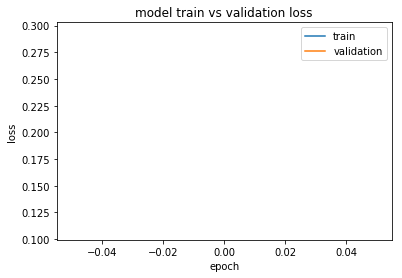

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [27]:
tf.reset_default_graph()

In [28]:
embedding.shape

TensorShape([Dimension(None), Dimension(None), Dimension(1024)])

In [ ]:
# since default shape exp is expected
# I feel here it has returned sentence level embedding